End read ../data/window.dr72safe0.ply


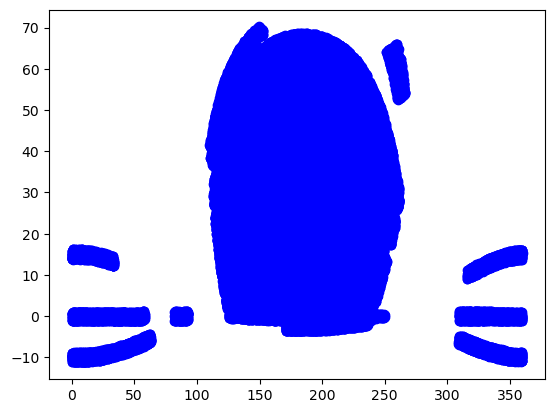

In [32]:
import pymangle as mangle
import numpy as np
import matplotlib.pyplot as plt

polyfile = "../data/window.dr72safe0.ply"
mng = mangle.Mangle(polyfile)
print("End read %s" % polyfile)

ra, dec = mng.genrand(100000)
plt.plot(ra, dec, 'bo')
plt.show()

In [43]:
# Read redshift from SDSS and apply it to randoms

import numpy as np
import scipy as sp
import pandas as pd

def apply_mask_sdss(cat_sdss, zmin, zmax):

  mask  = (cat_sdss["red"] > zmin)*(cat_sdss["red"] < zmax)
  mask *= (cat_sdss["ra"]>=100.)*(cat_sdss["ra"]<=275.0) # corta los bigotes
  mask *= ~((cat_sdss["ra"]>250.)*(cat_sdss["ra"]<270.0)*(cat_sdss["dec"]>50.0)*(cat_sdss["dec"]<70.0))   # corta una esquina
  mask *= ~((cat_sdss["ra"]>100.0)*(cat_sdss["ra"]<120.0)*(cat_sdss["dec"]>60.0)*(cat_sdss["dec"]<70.0))  # corta una esquina
  mask *= ~((cat_sdss["ra"]>256.6)*(cat_sdss["ra"]<270.0)*(cat_sdss["dec"]>39.2)*(cat_sdss["dec"]<70.0))  # corta una esquina
  mask *= ~((cat_sdss["ra"]>100.0)*(cat_sdss["ra"]<128.0)*(cat_sdss["dec"]>0.0)*(cat_sdss["dec"]<1.5))    # corta una esquina
  mask *= ~((cat_sdss["ra"]>263.0)*(cat_sdss["ra"]<270.0)*(cat_sdss["dec"]>23.0)*(cat_sdss["dec"]<40.0))  # corta una esquina
  mask *= ~((cat_sdss["ra"]>261.4)*(cat_sdss["ra"]<263.0)*(cat_sdss["dec"]>31.7)*(cat_sdss["dec"]<35.0))  # corta una esquina
  mask *= ~((cat_sdss["ra"]>252.5)*(cat_sdss["ra"]<255.0)*(cat_sdss["dec"]>13.0)*(cat_sdss["dec"]<14.5))  # corta una esquina
  mask *= ~((cat_sdss["ra"]>112.0)*(cat_sdss["ra"]<114.0)*(cat_sdss["dec"]>14.0)*(cat_sdss["dec"]<22.0))  # corta una esquina
  mask *= ~((cat_sdss["ra"]>114.0)*(cat_sdss["ra"]<115.5)*(cat_sdss["dec"]>14.0)*(cat_sdss["dec"]<19.4))  # corta una esquina
  mask *= ~((cat_sdss["ra"]>119.0)*(cat_sdss["ra"]<120.0)*(cat_sdss["dec"]>6.0)*(cat_sdss["dec"]<7.5))    # corta una esquina
  mask *= ~((cat_sdss["ra"]>100.0)*(cat_sdss["ra"]<110.0)*(cat_sdss["dec"]>35.0)*(cat_sdss["dec"]<40.1))  # corta una esquina
  mask *= ~((cat_sdss["ra"]>110.0)*(cat_sdss["ra"]<119.0)*(cat_sdss["dec"]>6.0)*(cat_sdss["dec"]<10.6))   # corta una esquina
  mask *= ~((cat_sdss["ra"]>110.0)*(cat_sdss["ra"]<112.5)*(cat_sdss["dec"]>30.0)*(cat_sdss["dec"]<36.5))  # corta una esquina
  mask *= ~((cat_sdss["ra"]>112.9)*(cat_sdss["ra"]<113.3)*(cat_sdss["dec"]>35.0)*(cat_sdss["dec"]<35.8))  # corta una esquina
  mask *= ~((cat_sdss["ra"]>114.2)*(cat_sdss["ra"]<114.3)*(cat_sdss["dec"]>35.06)*(cat_sdss["dec"]<36.2)) # corta una esquina
  #mask *= ~((cat_sdss["ra"]>245.0)*(cat_sdss["ra"]<270.0)*(cat_sdss["dec"]>0.0)*(cat_sdss["dec"]<3.0)) # corta una esquina

  return cat_sdss[mask]

def build_cdf_inv(v, vmin, vmax):

  v_sort  = np.sort(v)
  cdf     = np.arange(1, len(v_sort) + 1) / len(v_sort)
  cdf_inv = sp.interpolate.interp1d(cdf, v_sort, bounds_error=False, fill_value=(vmin, vmax))

  return cdf_inv 

cat_sdss = pd.read_csv('../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv')
cat_sdss_mask = apply_mask_sdss(cat_sdss,0,0.15)

cdf_inv_z = build_cdf_inv(cat_sdss_mask['red'], 0, 0.15)

u = np.random.uniform(0, 1, 100000)
random_red = cdf_inv_z(u)

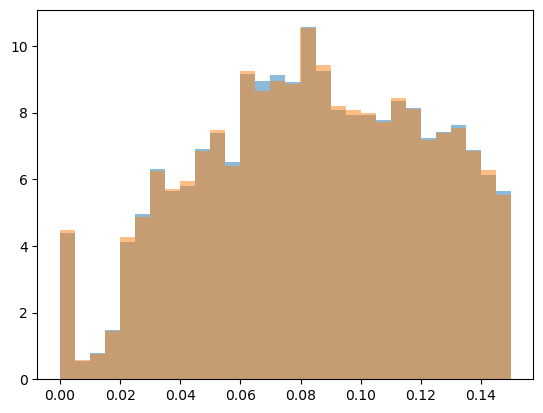

In [44]:
plt.hist(cat_sdss_mask['red'],bins=30, alpha=.5, color='C00', density=True)
plt.hist(random_red,bins=30, alpha=.5, color='C01', density=True)
plt.show()

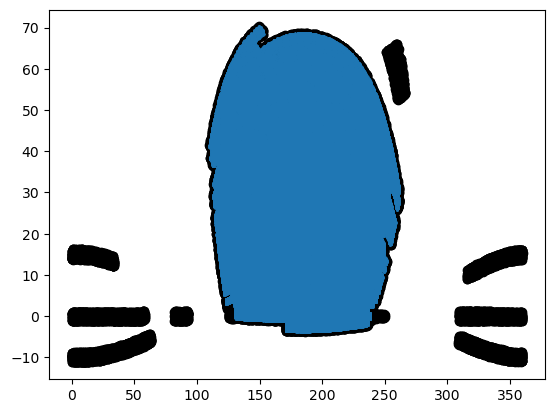

In [45]:
# Plot SDSS and randoms

plt.scatter(ra,dec,color='k')
plt.scatter(cat_sdss['ra'], cat_sdss['dec'],color='C00',s=1)
plt.show()

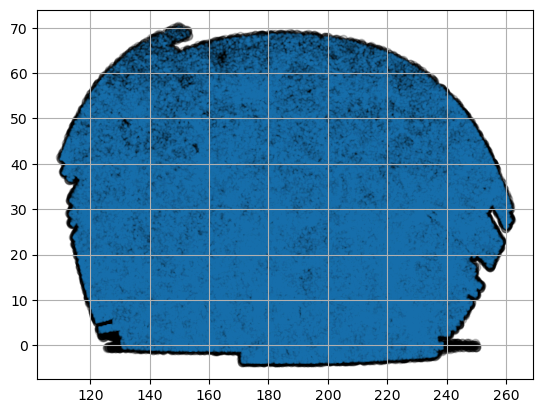

In [46]:
# Create panda frame for randoms and apply mask

import pandas as pd

randoms = pd.DataFrame({
        'ra':ra,
        'dec': dec,
        'red': random_red,
})

randoms_mask = apply_mask_sdss(randoms,0,0.15)

plt.scatter(randoms_mask['ra'],randoms_mask['dec'],color='k',alpha=.2)
plt.scatter(cat_sdss['ra'], cat_sdss['dec'],color='C00',s=1,alpha=.1)
plt.grid()
plt.show()

### Let's try healpix

In [12]:
import numpy as np
import healpy as hp
import pandas as pd
import scipy as sp

def build_cdf_inv(v, vmin, vmax):

  v_sort  = np.sort(v)
  cdf     = np.arange(1, len(v_sort) + 1) / len(v_sort)
  cdf_inv = sp.interpolate.interp1d(cdf, v_sort, bounds_error=False, fill_value=(vmin, vmax))

  return cdf_inv 
  
# Example: Load galaxy data
galaxy_data = pd.read_csv('../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv')
ra = galaxy_data['ra'].values  # Right Ascension
dec = galaxy_data['dec'].values  # Declination

# Set the resolution (nside)
nside = 128  # Approx 55 arcmin resolution (adjust as needed)

# Total number of pixels in the map
npix = hp.nside2npix(nside)

# Initialize a mask array (1 = valid, 0 = invalid)
mask = np.zeros(npix, dtype=int)

# Convert RA, Dec to Healpix indices
theta = np.radians(90 - dec)  # Declination to colatitude
phi = np.radians(ra)          # Right Ascension to longitude
pixels = hp.ang2pix(nside, theta, phi)

# Mark these pixels as valid
mask[pixels] = 1

num_randoms = 40000000  # Number of random points

# Generate uniform random RA, Dec
ra_random = np.random.uniform(0, 360, num_randoms)  # RA: 0 to 360 degrees
dec_random = np.random.uniform(-90, 90, num_randoms)  # Dec: -90 to 90 degrees

# Convert RA, Dec to Healpix indices
theta_random = np.radians(90 - dec_random)
phi_random = np.radians(ra_random)
random_pixels = hp.ang2pix(nside, theta_random, phi_random)

# Apply the mask
valid_indices = mask[random_pixels] == 1
ra_random = ra_random[valid_indices]
dec_random = dec_random[valid_indices]

# Read redshift distribution and apply to randoms
zmin, zmax = 0.0, 0.15
cat_sdss = pd.read_csv('../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv')
cat_sdss  = cat_sdss[(cat_sdss["red"] > zmin)*(cat_sdss["red"] < zmax)]

cdf_inv_z = build_cdf_inv(cat_sdss['red'], zmin, zmax)

u = np.random.uniform(0, 1, len(ra_random))
red_random = cdf_inv_z(u)

random_data = pd.DataFrame({
    'ra': ra_random,
    'dec': dec_random,
    'red': red_random
})

print(len(random_data))

random_data.to_csv(f'../data/random_sample_healpy_{nside}.csv', index=False)


5595669


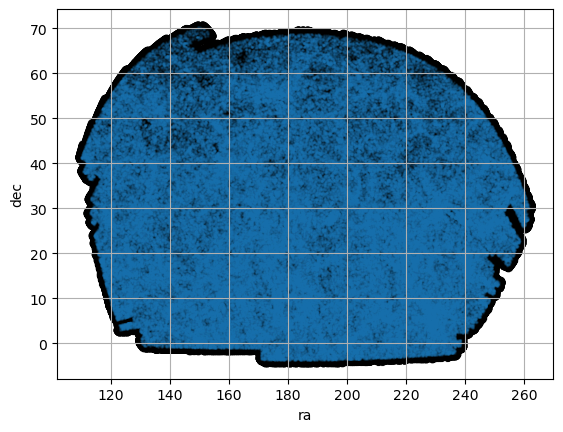

In [13]:
import matplotlib.pyplot as plt

plt.scatter(random_data['ra'],random_data['dec'],color='k',alpha=.2)
plt.scatter(cat_sdss['ra'], cat_sdss['dec'],color='C00',s=1,alpha=.1)
plt.xlabel('ra')
plt.ylabel('dec')
plt.grid()
plt.show()

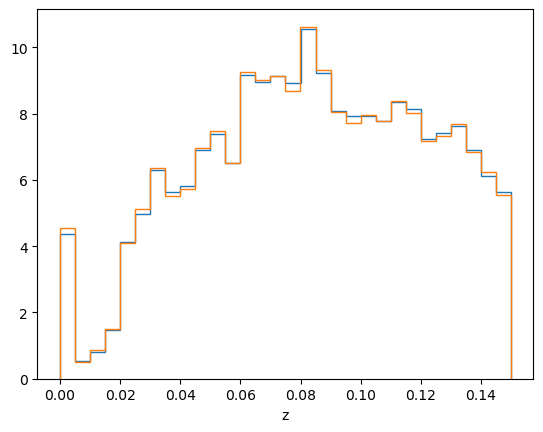

In [10]:
plt.hist(cat_sdss['red'],bins=30, color='C00', density=True, histtype='step')
plt.hist(random_data['red'],bins=30, color='C01', density=True, histtype='step')
plt.xlabel('z')
plt.show()

### Make a soft fit of the SDSS redshift distribution

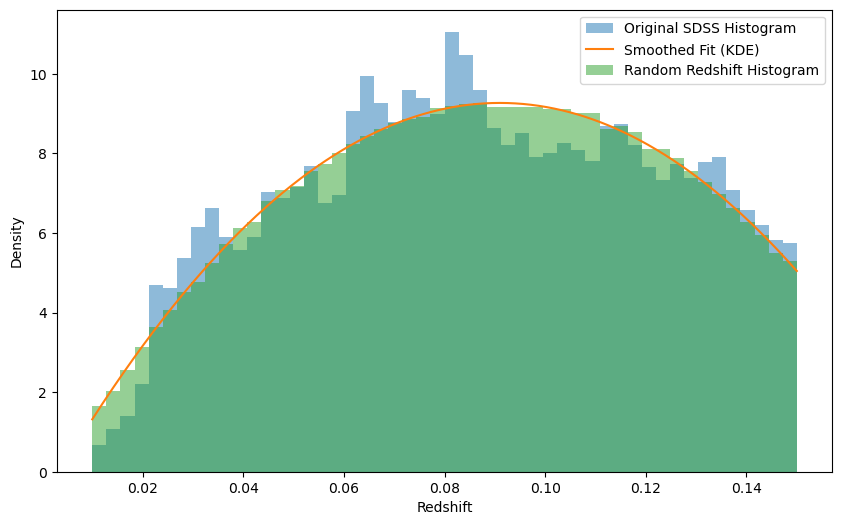

In [19]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

def build_cdf_from_parabola(data, vmin, vmax, num_points=1000):
    # Create a histogram of the redshifts
    hist, bin_edges = np.histogram(data, bins=50, range=(vmin, vmax), density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Fit a parabola (second-degree polynomial) to the histogram
    poly = Polynomial.fit(bin_centers, hist, deg=2)
    z_vals = np.linspace(vmin, vmax, num_points)
    pdf_vals = poly(z_vals)

    # Ensure the PDF is positive and normalized
    pdf_vals = np.clip(pdf_vals, a_min=0, a_max=None)
    pdf_vals /= np.trapz(pdf_vals, z_vals)  # Normalize the PDF

    # Build the CDF
    cdf_vals = np.cumsum(pdf_vals) * (z_vals[1] - z_vals[0])
    cdf_vals /= cdf_vals[-1]  # Normalize to [0, 1]

    # Create inverse CDF via interpolation
    cdf_inv = interp1d(cdf_vals, z_vals, bounds_error=False, fill_value=(vmin, vmax))
    return cdf_inv, z_vals, pdf_vals, cdf_vals

# Load and mask the SDSS data
cat_sdss = pd.read_csv('../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv')
cat_sdss = cat_sdss[(cat_sdss['red']>0.01)*(cat_sdss['red']<0.15)]

# Build the inverse CDF from a smoothed KDE fit
cdf_inv_z, z_vals, pdf_vals, cdf_vals = build_cdf_from_parabola(cat_sdss['red'], 0.01, 0.15)

# Generate random redshifts
u = np.random.uniform(0, 1, len(cat_sdss['red']))
random_red = cdf_inv_z(u)

# Plot results
plt.figure(figsize=(10, 6))
plt.hist(cat_sdss['red'], bins=50, density=True, alpha=0.5, label='Original SDSS Histogram')
plt.plot(z_vals, pdf_vals, label='Smoothed Fit (KDE)')
plt.hist(random_red, bins=50, density=True, alpha=0.5, label='Random Redshift Histogram')
plt.xlabel('Redshift')
plt.ylabel('Density')
plt.legend()
plt.show()
